### Importing packages

In [1]:
from holder.stock_holder import StockHolder
from backtest.simulator.bakctest_simulator import BackTestSimulator
from regression.LinearRegressionModel import LinearRegressionModel

## Data

### Defining some parameters

In [2]:
MOVING_AVERAGE_LIST = [(4, 8), (3, 5), (5, 15), (10, 20), (10, 30), (10, 40), (20, 30), (20, 40), (20, 50)]

INITIAL_CASH = 100, 000
MARKET_COMMISSION = 0.01

SAMPLE_STOCK_NAME = 'MAPNA'

### Reading sample data

In [3]:
stock_holder = StockHolder()

### data stats view

stock stats:
<bound method NDFrame.describe of        Name       Date     High      Low    Close    Volume     Open
0     MAPNA 2019-10-26   8793.0   8434.0   8507.0   4025586   8535.0
1     MAPNA 2019-10-28   8756.0   8570.0   8644.0   3396670   8507.0
2     MAPNA 2019-10-30   8990.0   8705.0   8849.0   6929651   8644.0
3     MAPNA 2019-11-02   9105.0   8428.0   8822.0   3698112   8850.0
4     MAPNA 2019-11-03   8958.0   8600.0   8798.0   7748497   8822.0
...     ...        ...      ...      ...      ...       ...      ...
1089  MAPNA 2024-10-13  11560.0  11130.0  11200.0  15671221  11470.0
1090  MAPNA 2024-10-14  11190.0  10870.0  11070.0   4432100  11200.0
1091  MAPNA 2024-10-15  10740.0  10740.0  11050.0    750361  11070.0
1092  MAPNA 2024-10-16  10720.0  10720.0  10990.0   1729490  11050.0
1093  MAPNA 2024-10-19  10670.0  10670.0  10950.0   1500022  10990.0

[1094 rows x 7 columns]>


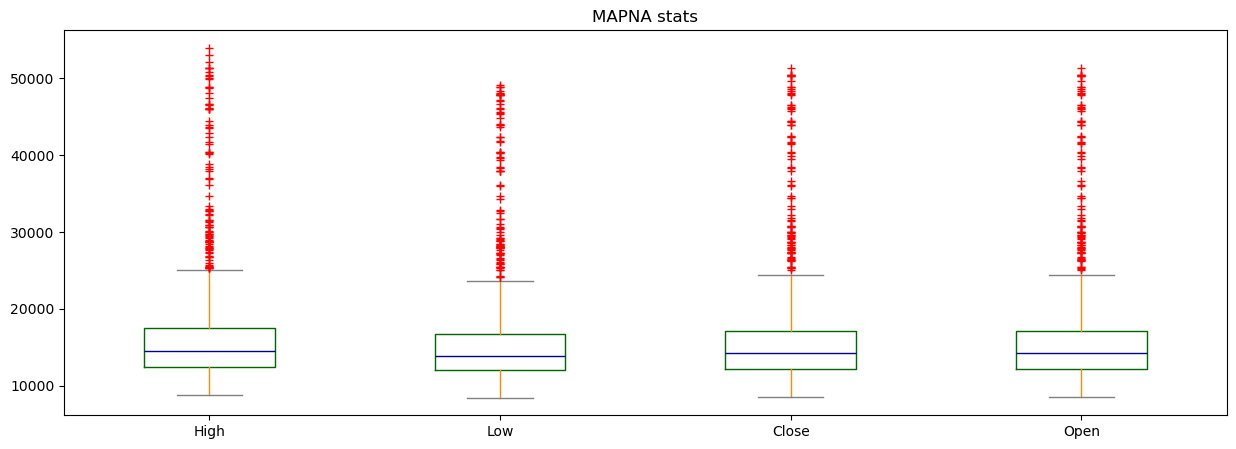

In [4]:
stock_holder.describe_plot(SAMPLE_STOCK_NAME)

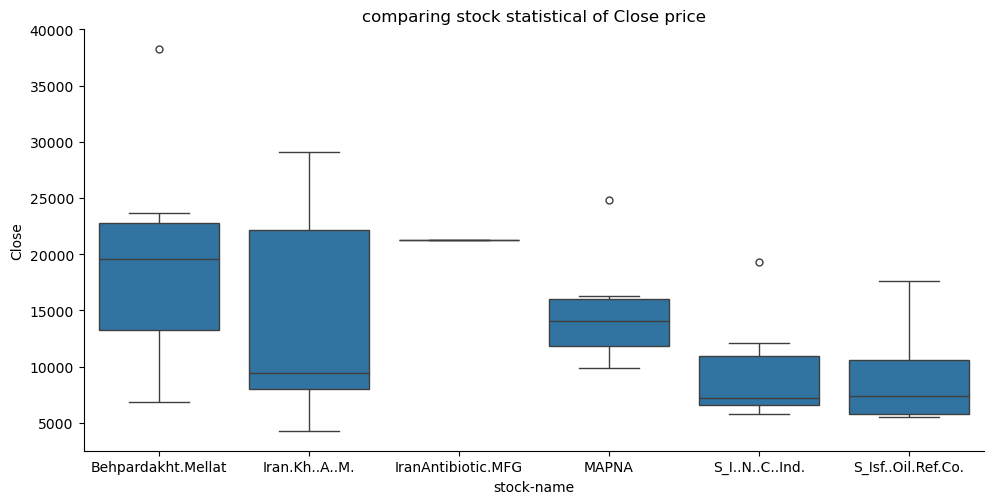

In [5]:
stock_holder.describe_together_single_col()

### closing - opening price

last 100 days

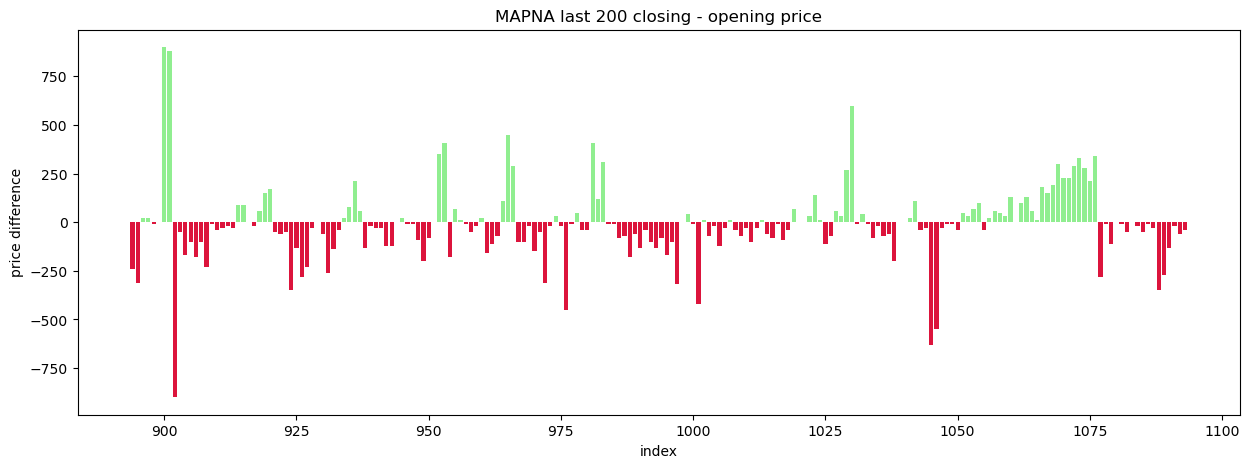

In [6]:
stock_holder.close_open_diff(SAMPLE_STOCK_NAME, period_in_day=200, is_head=False)

#### year by year mean

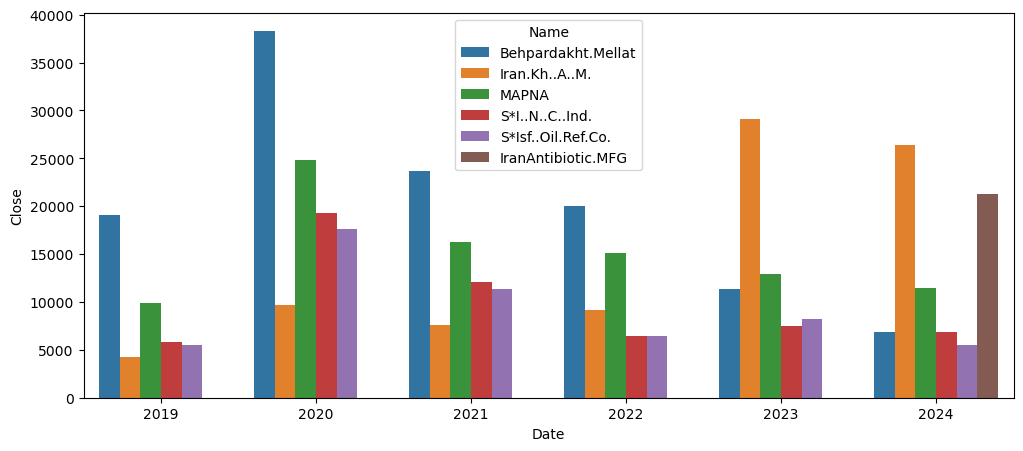

In [7]:
stock_holder.year_mean_compare()

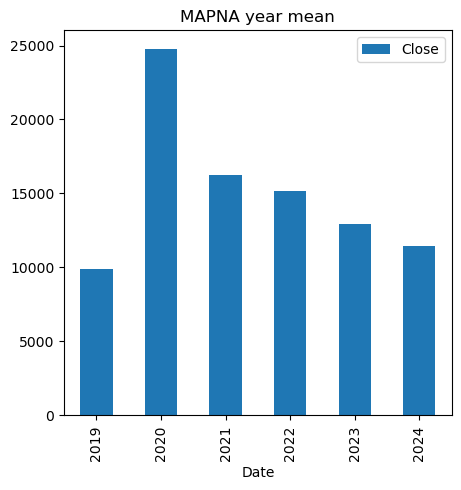

In [8]:
stock_holder.year_mean(SAMPLE_STOCK_NAME, figsize=(5, 5))

#### each year mean - average of last five years

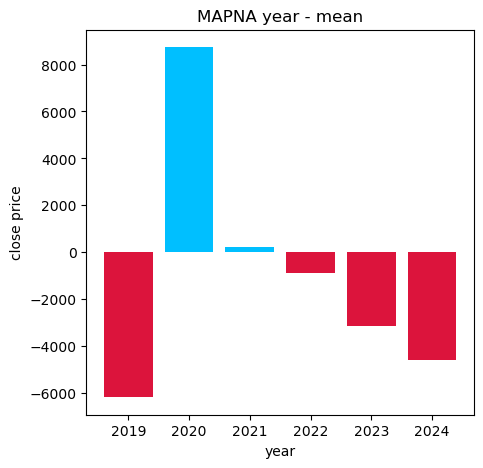

In [9]:
stock_holder.year_mean_diff(SAMPLE_STOCK_NAME, figsize=(5, 5))

### Data visualization

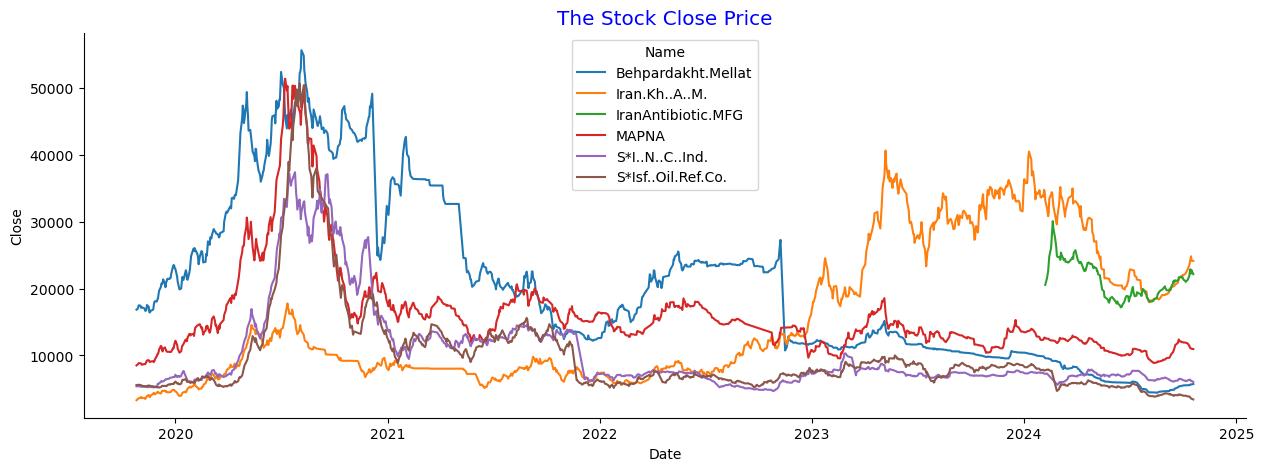

In [10]:
stock_holder.data_plot_compare('Close')

single stock

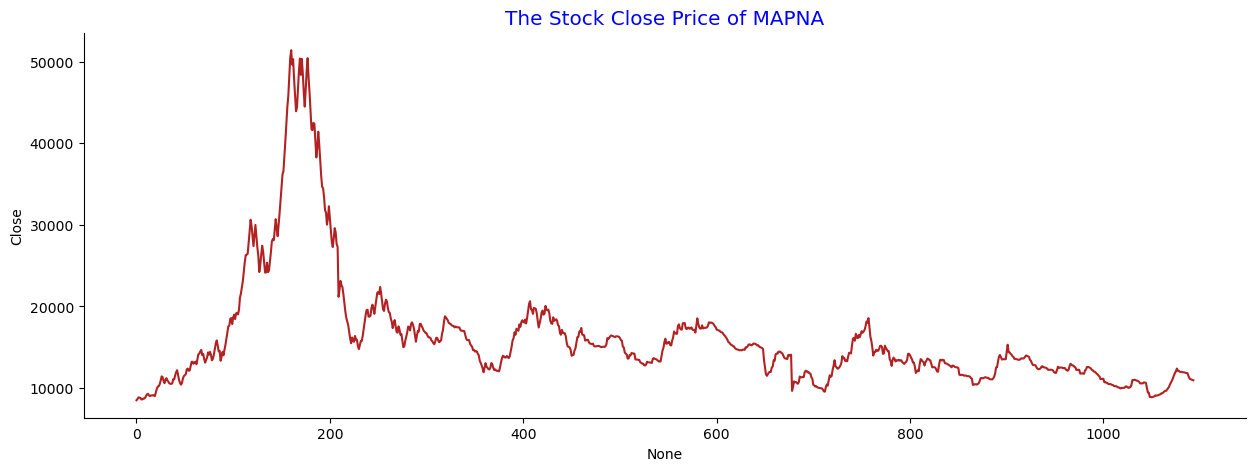

In [11]:
stock_holder.data_plot_single_stock(SAMPLE_STOCK_NAME,
                                    is_number_index=True)  # change it to false in order to get date index

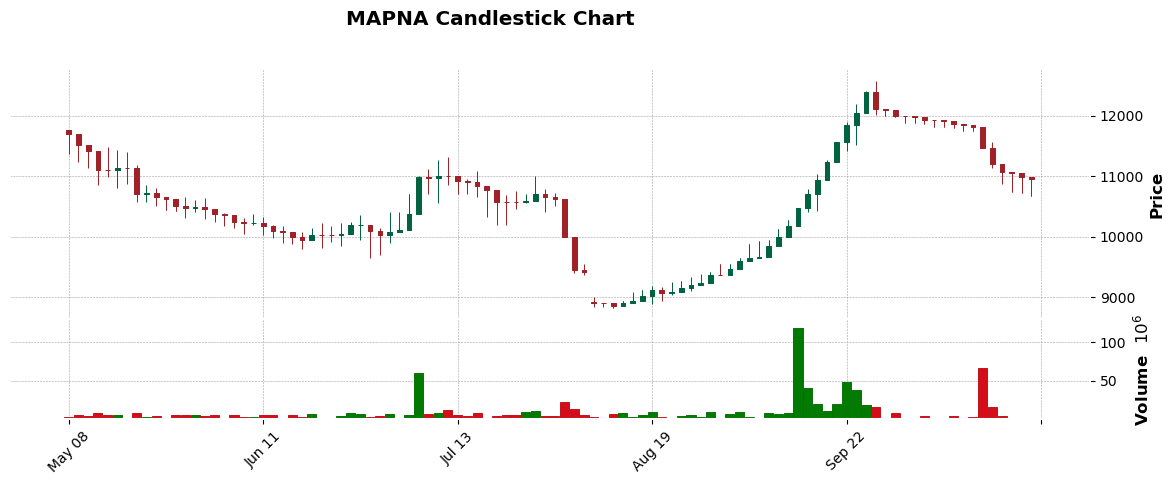

In [12]:
stock_holder.mpf_last_days_view(SAMPLE_STOCK_NAME, days=100)

## Moving Average Simulation

In [13]:
simulator = BackTestSimulator(stock_holder.get_samples(), stock_holder.get_stock_names(), MOVING_AVERAGE_LIST)
simulator.simulate(is_log_disabled=True)

#### General View

In [14]:
#simulator.best_stock_ma_comparison(SAMPLE_STOCK_NAME, figsize=(15, 7))

#### SMA result

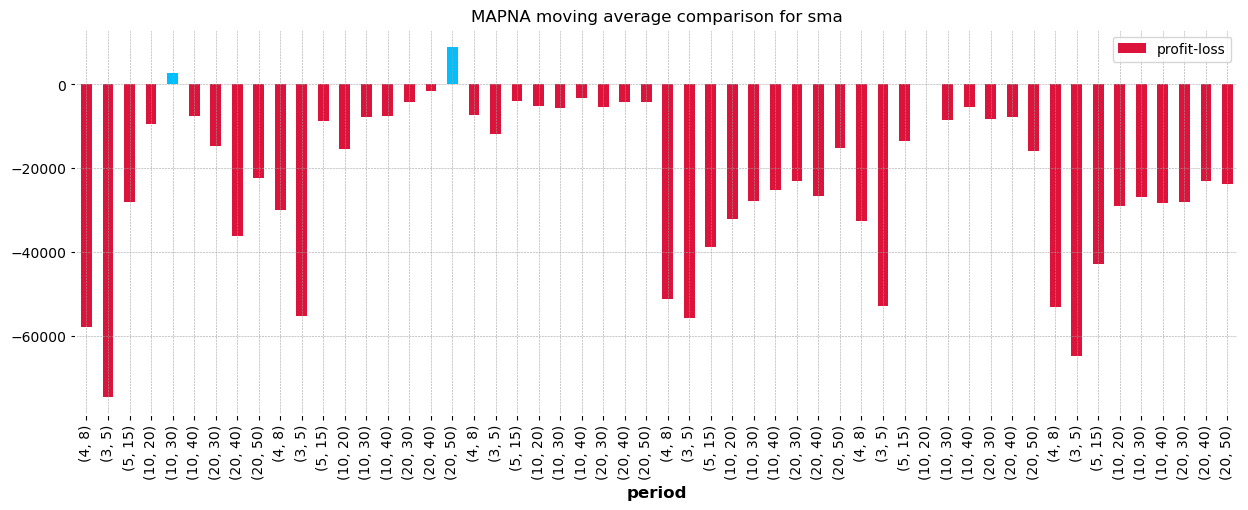

In [15]:
simulator.stock_ma_compare_plot(SAMPLE_STOCK_NAME, sma=True)

#### EMA result

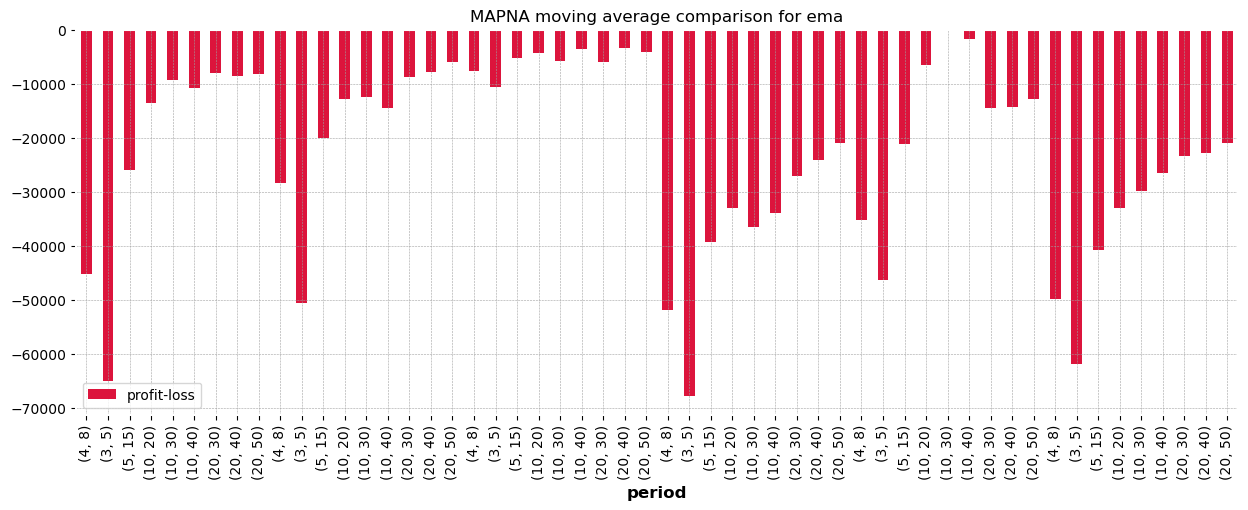

In [16]:
simulator.stock_ma_compare_plot(SAMPLE_STOCK_NAME, sma=False)

#### Comparing EMA vs SMA

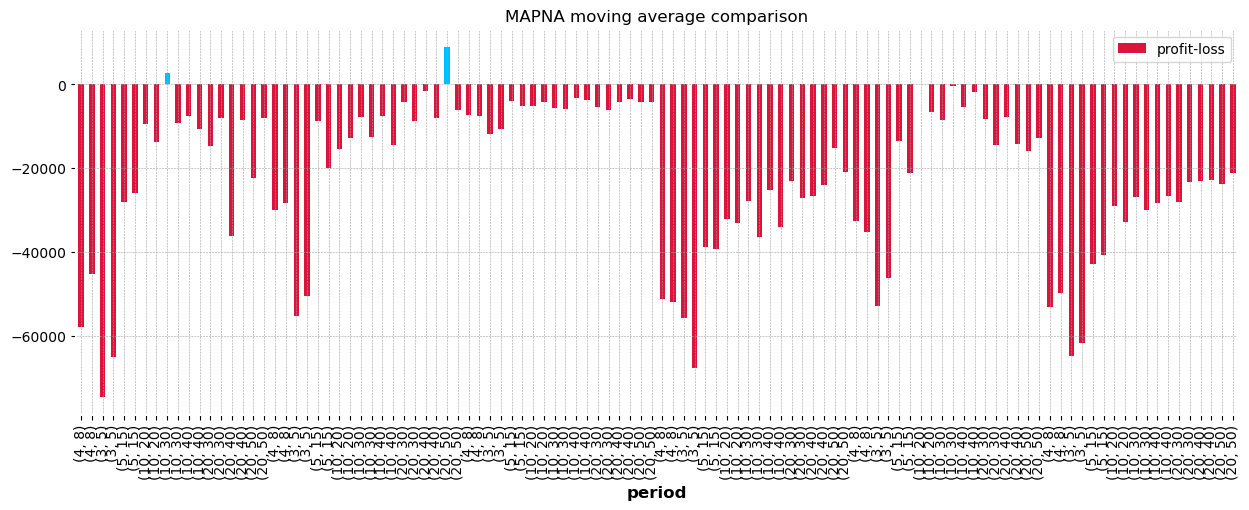

In [17]:
simulator.stock_ma_compare_plot(SAMPLE_STOCK_NAME, sma=None)

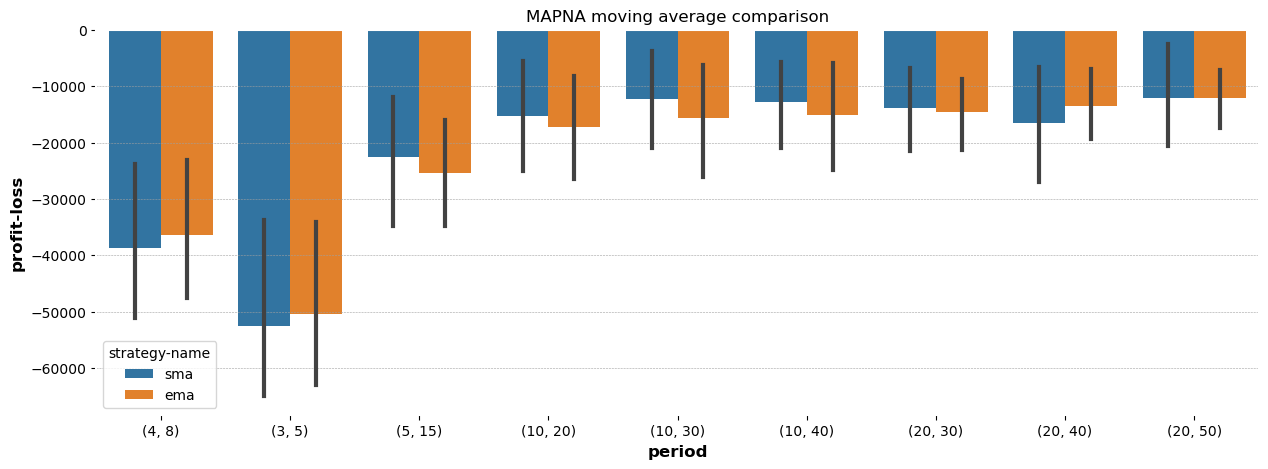

In [18]:
simulator.stock_compare_sma_and_ema(SAMPLE_STOCK_NAME)

### Linear Regression

In [19]:
lr = LinearRegressionModel(stock_holder.get_samples()[SAMPLE_STOCK_NAME], SAMPLE_STOCK_NAME, period_max=30, pred_min=0.0)

#### plot regions

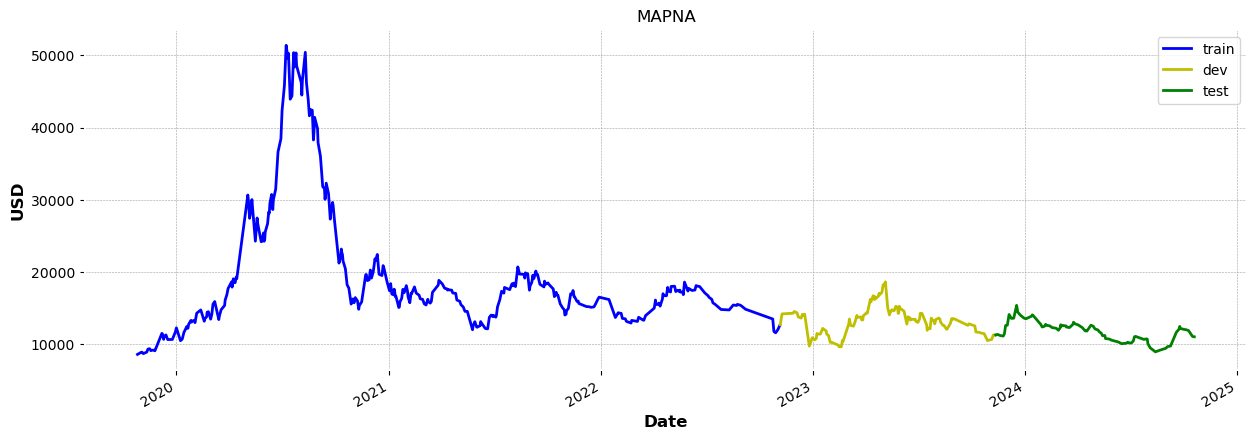

In [20]:
lr.plot_regions()

#### apply regression

In [21]:
lr.apply_regression()

#### plotting parameters

##### rms

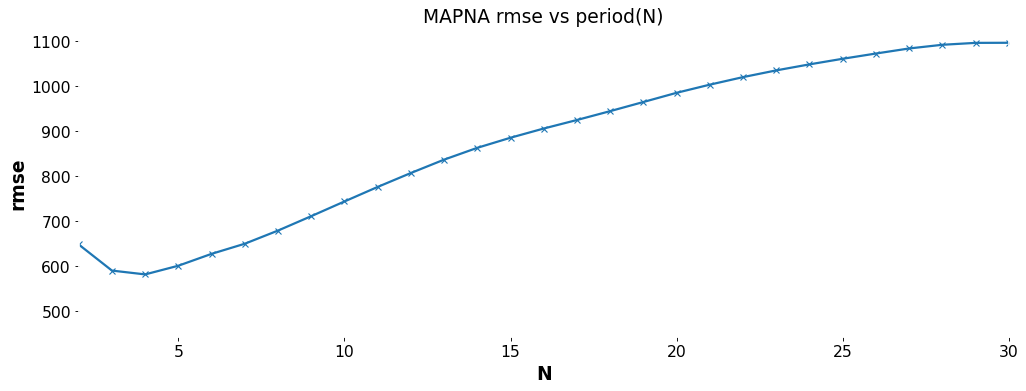

In [22]:
lr.plot_param_vs_period(LinearRegressionModel.rmse)

##### r2

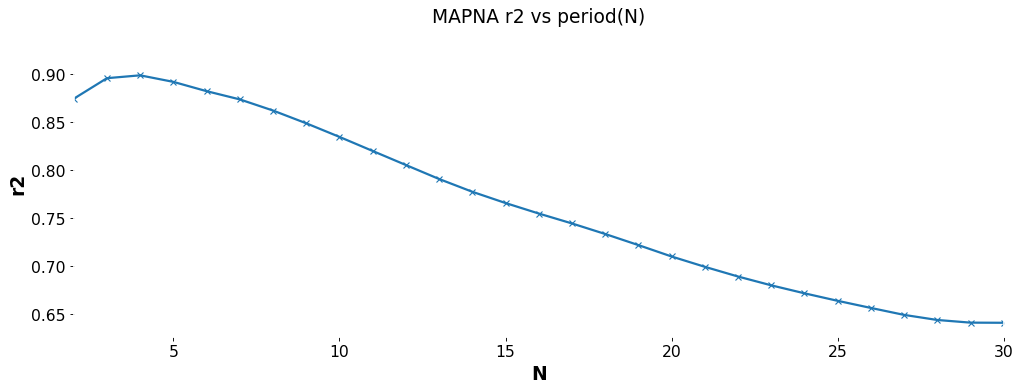

In [23]:
lr.plot_param_vs_period(LinearRegressionModel.r2)


##### mape

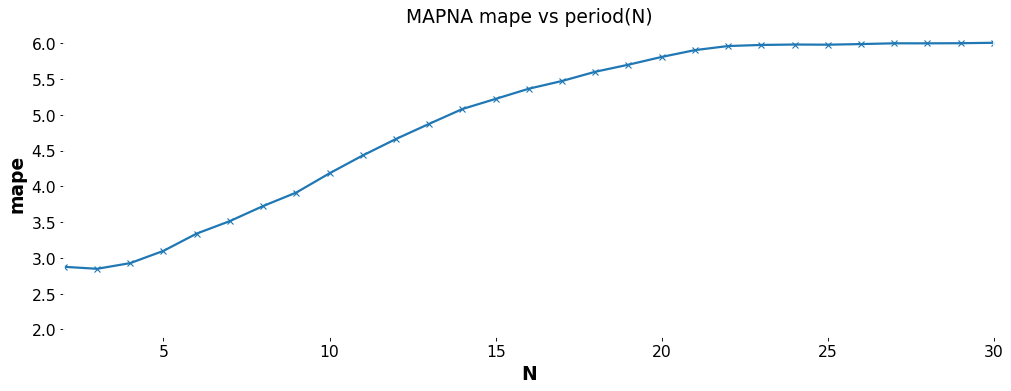

In [24]:
lr.plot_param_vs_period(LinearRegressionModel.mape)

In [ ]:
1- complete Linear regression model from file and make a general model for that
2- remove above usage of LinearRegression mode and correct them 

In [25]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from pylab import rcParams


class LinearRegressionModel:
    r2 = 'r2'
    rmse= 'rmse'
    mape = 'mape'
    
    def __init__(self, df: pd.DataFrame, stock_name: str, period_max=30, pred_min: float = 0.0, test_size: float = 0.2,
                 cv_size: float = 0.2, target_col: str='Close'):
        self.__df = df
        self.__stock_name = stock_name
        self.__period_max = period_max
        self.__pred_min = pred_min
        self.__test_size = test_size  # proportion of dataset to be used as test set
        self.__cv_size = cv_size  # proportion of dataset to be used as cross-validation set
        self.__mape = []
        self.__rmse = []
        self.__r2 = []
        self.__target_col = target_col
        self.__set_df_parts_len()
        self.__set_df_parts()
        
    def get_mape(self, y_true, y_pred):
        """
        Compute mean absolute percentage error (MAPE)
        """
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    def __set_df_parts_len(self):
        self.__num_cv = int(self.__cv_size*len(self.__df))
        self.__num_test = int(self.__test_size*len(self.__df))
        self.__num_train = len(self.__df) - self.__num_cv - self.__num_test
        
    def get_df_parts_len(self):
        """
        return: number len of cross validation(cv), test size and train size
        """
        return self.__num_cv, self.__num_test, self.__num_train
    
    def __set_df_parts(self):
        self.__train = self.__df[:self.__num_train].copy()
        self.__cv = self.__df[self.__num_train:self.__num_train+self.__num_cv].copy()
        self.__train_cv = self.__df[:self.__num_train+self.__num_cv].copy()
        self.__test = self.__df[self.__num_train+self.__num_cv:].copy()
    
    def get_df_parts(self):
        """
        It gets different len of train, test and cross validation and separates dataframe in relative parts
        :return: train, cross validation(cv), train_cv and test data frames 
        """
        return self.__train, self.__cv, self.__train_cv,self.__test
    
    def plot_regions(self, figsize:tuple[int, int]=(15, 5)):
        rcParams['figure.figsize'] = figsize
        ax = self.__train.plot(x='Date', y=self.__target_col, style='b-', grid=True)
        ax = self.__cv.plot(x='Date', y=self.__target_col, style='y-', grid=True, ax=ax)
        ax = self.__test.plot(x='Date', y=self.__target_col, style='g-', grid=True, ax=ax)
        ax.legend(['train', 'dev', 'test'])
        ax.set_xlabel('Date')
        ax.set_ylabel('USD')
        plt.title(f'{self.__stock_name}')
        plt.show()

    def apply_regression(self):
        regr = LinearRegression(fit_intercept=True)
        pred_list = np.array([])

        for period in range(1, self.__period_max + 1):
            est_list = self.__apply_regression_for_period(period=period, offset=self.__num_train)
            self.__cv.loc[:, 'est' + '-period:' + str(period)] = est_list
            self.__rmse.append(math.sqrt(mean_squared_error(est_list, self.__cv[self.__target_col])))
            self.__r2.append(r2_score(self.__cv[self.__target_col], est_list))
            self.__mape.append(self.get_mape(self.__cv[self.__target_col], est_list))

    def __apply_regression_for_period(self, period:int, offset:int):
        """
        Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
        Inputs
            df         : dataframe with the values you want to predict. Can be of any length.
            target_col : name of the column you want to predict e.g. 'adj_close'
            N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
            pred_min   : all predictions should be >= pred_min
            offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
        Outputs
            pred_list  : the predictions for target_col. np.array of length len(df)-offset.
        """
        # Create linear regression object
        regr = LinearRegression(fit_intercept=True)
    
        pred_list = []
        df = self.__train_cv
    
        for i in range(offset, len(self.__train_cv[self.__target_col])):
            X_train = np.array(range(len(self.__train_cv[self.__target_col][i - period:i])))  # e.g. [0 1 2 3 4]
            y_train = np.array(self.__train_cv[self.__target_col][i - period:i])  # e.g. [2944 3088 3226 3335 3436]
            X_train = X_train.reshape(-1, 1)  # e.g X_train =
            # [[0]
            #  [1]
            #  [2]
            #  [3]
            #  [4]]
            # X_train = np.c_[np.ones(N), X_train]              # add a column
            y_train = y_train.reshape(-1, 1)
            #     print X_train.shape
            #     print y_train.shape
            #     print 'X_train = \n' + str(X_train)
            #     print 'y_train = \n' + str(y_train)
            regr.fit(X_train, y_train)  # Train the model
            pred = regr.predict(np.array(period).reshape(1, -1))
    
            pred_list.append(pred[0][0])  # Predict the footfall using the model
    
        # If the values are < pred_min, set it to be pred_min
        pred_list = np.array(pred_list)
        pred_list[pred_list < self.__pred_min] = self.__pred_min
    
        return pred_list
    
    def plot_param_vs_period(self, param:str=None, figsize:tuple[int, int]=(15, 5)):
        if param == self.rmse:
            y = self.__rmse
        elif param == self.mape:
            y = self.__mape
        elif param == self.r2:
            y = self.__r2
        else:
            raise ValueError(f'Parameter {param} is not valid')
        
        # Plot RMSE versus N
        matplotlib.rcParams.update({'font.size': 14})
        plt.figure(figsize=figsize, dpi=80)
        plt.plot(range(1, self.__period_max+1), y, 'x-')
        plt.grid()
        plt.xlabel('N')
        plt.ylabel(param)
        plt.xlim([2, 30])
        plt.title(f'{self.__stock_name} {param} vs period(N)')
        plt.show()

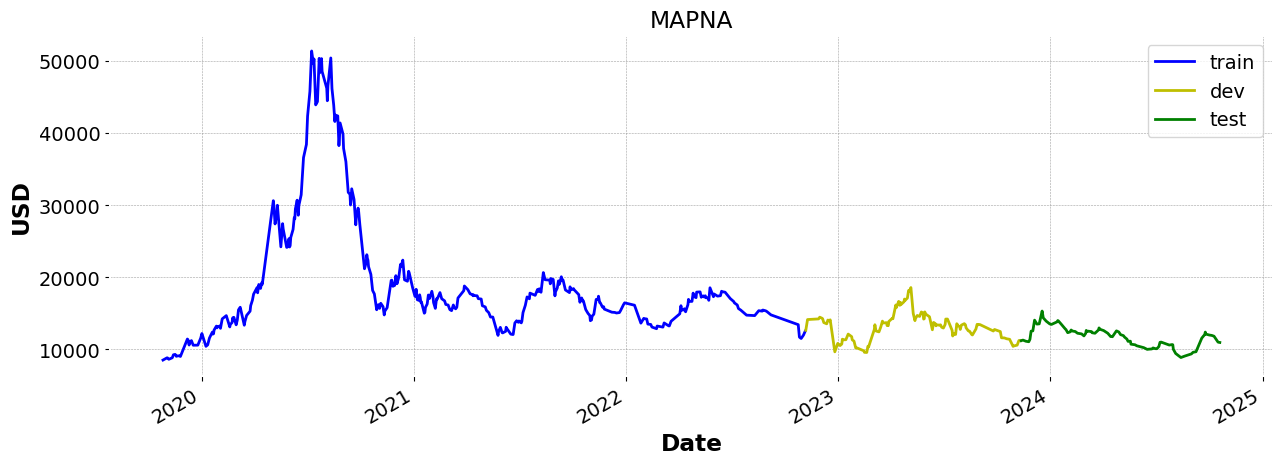

In [26]:
lr = LinearRegressionModel(stock_holder.get_samples()['MAPNA'], 'MAPNA', period_max=30, pred_min=0.0)
lr.plot_regions()

In [27]:
lr.apply_regression()

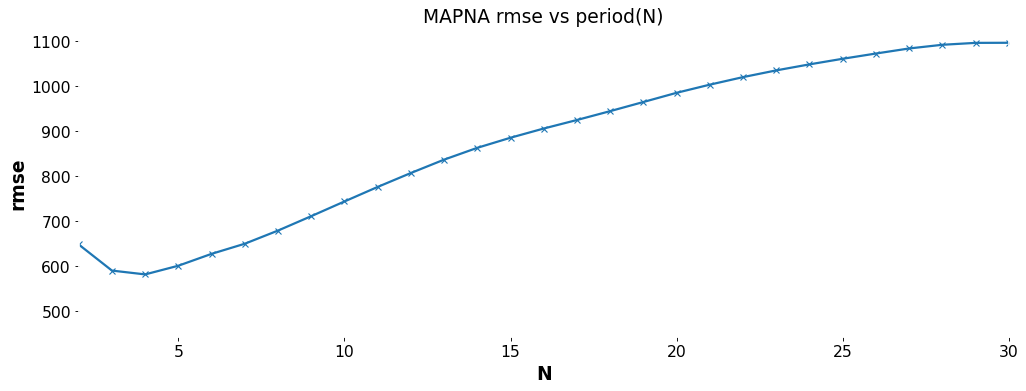

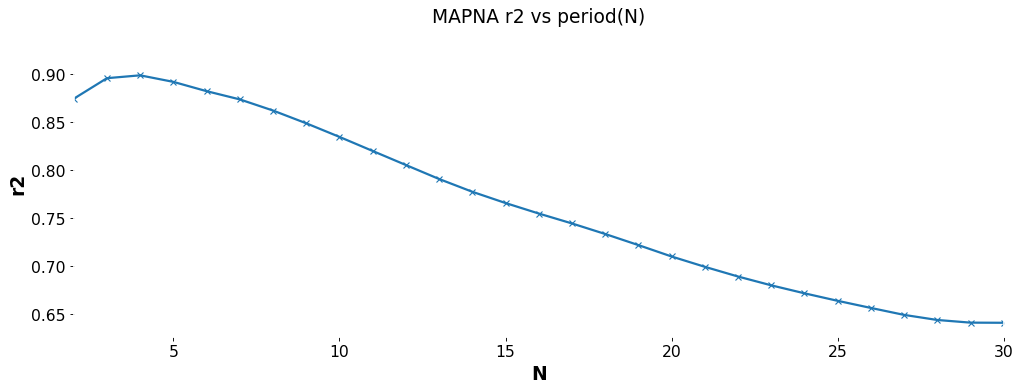

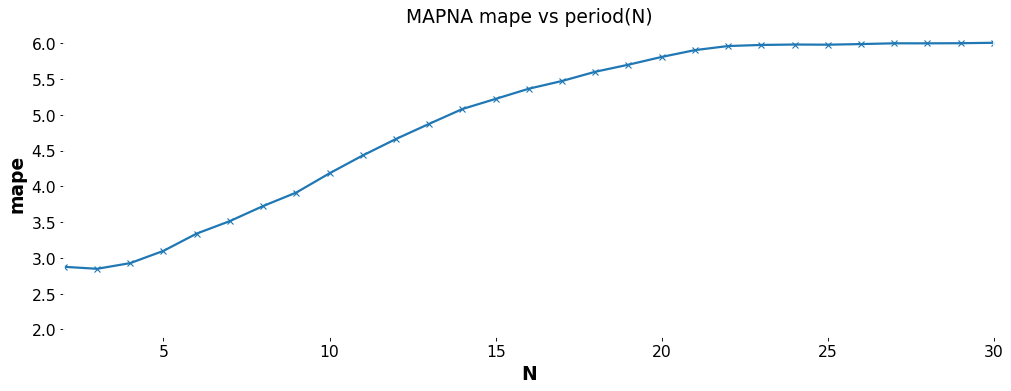

In [28]:
lr.plot_param_vs_period(LinearRegressionModel.rmse)
lr.plot_param_vs_period(LinearRegressionModel.r2)
lr.plot_param_vs_period(LinearRegressionModel.mape)